# Simple implementation of evolutionary algorithm

In [10]:
import numpy as np 
import random

random.seed(0)
np.random.seed(0)
import matplotlib.pyplot as plt

dim = 3

In [11]:
square_func = lambda t: t[0]**2 + t[1]**2 + 2*t[2]**2

In [12]:
def create_population(population_size, dim, low=-10, high=10):
    return np.random.uniform(low, high, (population_size, dim))

population = create_population(10, dim)
population

array([[ 0.97627008,  4.30378733,  2.05526752],
       [ 0.89766366, -1.52690401,  2.91788226],
       [-1.24825577,  7.83546002,  9.27325521],
       [-2.33116962,  5.83450076,  0.5778984 ],
       [ 1.36089122,  8.51193277, -8.57927884],
       [-8.25741401, -9.59563205,  6.65239691],
       [ 5.56313502,  7.40024296,  9.57236684],
       [ 5.98317128, -0.77041275,  5.61058353],
       [-7.63451148,  2.79842043, -7.13293425],
       [ 8.89337834,  0.43696644, -1.7067612 ]])

In [13]:
def get_best(population, func):
    values = np.array([func(t) for t in population])
    best_idx = np.argmin(values)
    return population[best_idx], values[best_idx]

get_best(population, square_func)

(array([ 0.89766366, -1.52690401,  2.91788226]), 20.165309693971327)

## Gaussian noise

In [14]:
def gaussian_mutation(population, low = -10, high = 10, sigma_0=1, mu = 0):
    # https://www.iue.tuwien.ac.at/phd/heitzinger/node27.html
    
    sigma = sigma_0 * (high - low)
    mutate = np.random.binomial(1, 0.2, population.shape)
    gaussian_noise = np.random.normal(mu, sigma, population.shape)  * mutate  
    new_population = population + gaussian_noise
    new_population = np.clip(new_population, low, high)
    
    return new_population

## Crossover

In [15]:
def single_point_crossover(individual1, individual2):
    dim = len(individual1)
    crossover_point = np.random.randint(0, dim)
    
    new_individual1 = np.zeros(dim)
    new_individual2 = np.zeros(dim)
    
    new_individual1[:crossover_point] = individual1[:crossover_point]
    new_individual1[crossover_point:] = individual2[crossover_point:]
    
    new_individual2[:crossover_point] = individual2[:crossover_point]
    new_individual2[crossover_point:] = individual1[crossover_point:]
    
    return new_individual1, new_individual2
    

def crossover(population):
    new_population = []
    
    for i in range(len(population)):
        if random.random() < 0.7:
            new_individuals = single_point_crossover(population[i], population[np.random.randint(0, len(population))])
            new_population.append(new_individuals[0])
            new_population.append(new_individuals[1])
        else:
            new_population.append(population[i])
    new_population = np.vstack(new_population)
    return new_population
    

In [16]:
import time

def run(max_iter = 100, tol = 0.01, max_time = 60, 
        population_size = 100, func = square_func, dim = 3, low = -10, high = 10,
        sigma_0 = 1, elite = 10, temperature=1):
    # algorithm stops after iter iterations or if the best individual has not changed by more than tol
    assert elite < population_size
    
    start = time.time()
    res = [np.inf]
    avg_res = []
    population = create_population(population_size, dim)
    res.append(get_best(population, square_func)[1])
    avg_res.append(np.mean([square_func(t) for t in population]))
    iter = 0
    while iter < max_iter:
        print("Iteration: ", iter)
        print("Best individual: ", res[iter + 1])

        population = crossover(population)
        population = gaussian_mutation(population, sigma_0 = sigma_0)
        
        scores = np.array([func(t) for t in population])
        
        # sort population by scores
        population = population[np.argsort(scores)]
        
        # select the elite
        new_population = np.zeros((population_size, dim))
        new_population[:elite] = population[:elite]
        
        # apply softmax
        #scores = np.exp(-scores[elite:]) # the lower the score the better
        
        avg_res.append(np.mean(scores))
        scores = np.exp(-scores/temperature)
        scores = scores / np.sum(scores)        
        
        
        #new_population[elite:] = population[elite + np.random.choice(range(len(population) - elite), size = population_size - elite, p = scores)]
        
        # include the elite twice
        new_population[elite:] = population[np.random.choice(range(len(population)), size = population_size - elite, p = scores)]
        population = new_population
        best = get_best(population, square_func)
        res.append(best[1])
        iter += 1
        if time.time() - start > max_time:
            print("Time limit reached")
            
            return best, res, avg_res
    return best, res, avg_res

In [17]:
best, res, _ = run(population_size=10000, tol=0, sigma_0=0.1, elite = 100)

Iteration:  0
Best individual:  0.759812275225962
Iteration:  1
Best individual:  0.3392890593488401
Iteration:  2
Best individual:  0.31406823014441543
Iteration:  3
Best individual:  0.0005238829160487637
Iteration:  4
Best individual:  0.0005238829160487637
Iteration:  5
Best individual:  0.00790341910784686
Iteration:  6
Best individual:  0.0003617589604521507
Iteration:  7
Best individual:  0.0003617589604521507
Iteration:  8
Best individual:  0.0003617589604521507
Iteration:  9
Best individual:  8.896401205032497e-05
Iteration:  10
Best individual:  8.740420583613505e-05
Iteration:  11
Best individual:  8.740420583613505e-05
Iteration:  12
Best individual:  8.740420583613505e-05
Iteration:  13
Best individual:  8.740420583613505e-05
Iteration:  14
Best individual:  8.740420583613505e-05
Iteration:  15
Best individual:  8.740420583613505e-05
Iteration:  16
Best individual:  8.740420583613505e-05
Iteration:  17
Best individual:  8.740420583613505e-05
Iteration:  18
Best individual:

Text(0, 0.5, 'Best individual')

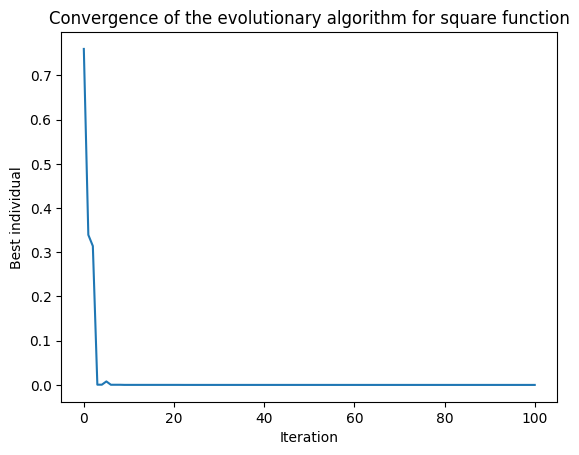

In [18]:
import matplotlib.pyplot as plt

plt.plot(res[1:])
plt.title("Convergence of the evolutionary algorithm for square function")
plt.xlabel("Iteration")
plt.ylabel("Best individual")

Iteration:  0
Best individual:  0.18836840854171788
Iteration:  1
Best individual:  0.18836840854171788
Iteration:  2
Best individual:  0.13408077847077418
Iteration:  3
Best individual:  0.0730799729437774
Iteration:  4
Best individual:  0.005062394573454243
Iteration:  5
Best individual:  0.0025750564498509937
Iteration:  6
Best individual:  0.0025750564498509937
Iteration:  7
Best individual:  0.0025750564498509937
Iteration:  8
Best individual:  0.0025750564498509937
Iteration:  9
Best individual:  0.0025750564498509937
Iteration:  10
Best individual:  0.0024214170746047416
Iteration:  11
Best individual:  0.0009431957095943392
Iteration:  12
Best individual:  9.840661632295321e-05
Iteration:  13
Best individual:  9.840661632295321e-05
Iteration:  14
Best individual:  9.840661632295321e-05
Iteration:  15
Best individual:  9.840661632295321e-05
Iteration:  16
Best individual:  9.840661632295321e-05
Iteration:  17
Best individual:  3.4263748578329566e-05
Iteration:  18
Best individua

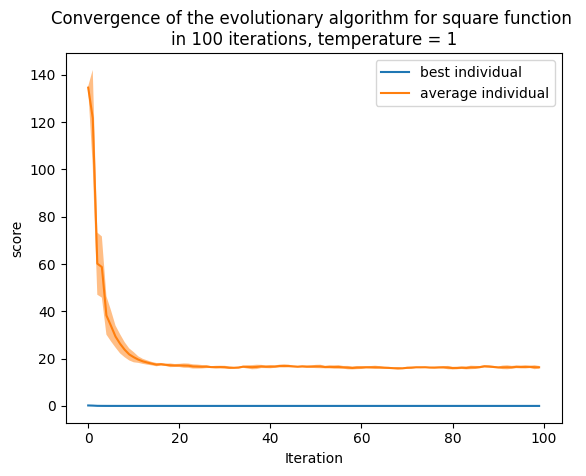

In [29]:
import seaborn as sns

max_iter = 100

n_times = 10
res = np.zeros((n_times, max_iter))
avg_res = np.zeros((n_times, max_iter))
for i in range(n_times):
    best, temp, avg_temp = run(max_iter=max_iter, population_size=10000, tol=0, sigma_0=0.1, elite = 1000, temperature=1)
    res[i] = temp[-max_iter:]
    avg_res[i] = avg_temp[-max_iter:]
    
plt.fill_between(range(max_iter), np.mean(res, axis = 0) - np.std(res, axis = 0), np.mean(res, axis = 0) + np.std(res, axis = 0), alpha = 0.5)
plt.fill_between(range(max_iter), np.mean(avg_res, axis = 0) - np.std(avg_res, axis = 0), np.mean(avg_res, axis = 0) + np.std(avg_res, axis = 0), alpha = 0.5)

plt.plot(range(max_iter), np.mean(res, axis = 0), label="best individual")
plt.plot(range(max_iter), np.mean(avg_res, axis = 0), label="average individual")

plt.title("Convergence of the evolutionary algorithm for square function \nin 100 iterations, temperature = 1")

plt.xlabel("Iteration")
plt.ylabel("score")
plt.legend()
plt.show()

In [30]:
print("Best individual: ", res[:,-1].mean(), "+-", res[:,-1].std())
print("Average individual: ", avg_res[:,-1].mean(), "+-", avg_res[:,-1].std())

Best individual:  1.0573259443086509e-07 +- 2.011306201376877e-07
Average individual:  16.340539280114516 +- 0.5585216498252851


Iteration:  0
Best individual:  3.4754550719799084
Iteration:  1
Best individual:  2.032873506636154
Iteration:  2
Best individual:  1.2626128284557174
Iteration:  3
Best individual:  0.615048128106549
Iteration:  4
Best individual:  0.02698838969622496
Iteration:  5
Best individual:  0.02698838969622496
Iteration:  6
Best individual:  0.012529232674875244
Iteration:  7
Best individual:  0.008816245631624264
Iteration:  8
Best individual:  0.008278421820421978
Iteration:  9
Best individual:  0.00036943922245913125
Iteration:  10
Best individual:  0.00036943922245913125
Iteration:  11
Best individual:  0.0008259119854020821
Iteration:  12
Best individual:  0.0008259119854020821
Iteration:  13
Best individual:  0.0006300318755831094
Iteration:  14
Best individual:  0.002316674263721408
Iteration:  15
Best individual:  0.001891852660455586
Iteration:  16
Best individual:  0.0019638620452560075
Iteration:  17
Best individual:  0.0018460664776116797
Iteration:  18
Best individual:  0.000370

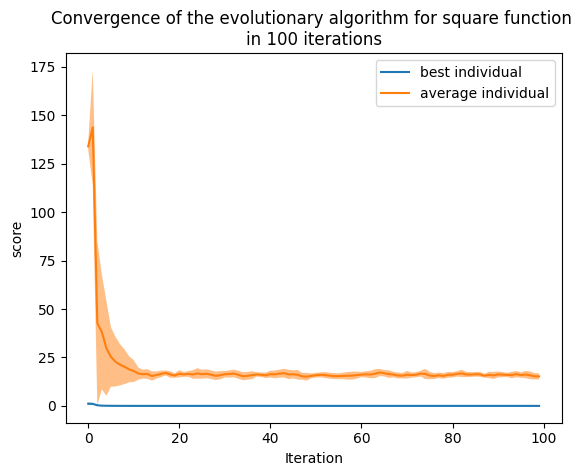

In [225]:
import seaborn as sns

max_iter = 100

n_times = 10
res = np.zeros((n_times, max_iter))
avg_res = np.zeros((n_times, max_iter))
for i in range(n_times):
    best, temp, avg_temp = run(max_iter=max_iter, population_size=1000, tol=0, sigma_0=0.1, elite = 100, temperature=1)
    res[i] = temp[-max_iter:]
    avg_res[i] = avg_temp[-max_iter:]
    
plt.fill_between(range(max_iter), np.mean(res, axis = 0) - np.std(res, axis = 0), np.mean(res, axis = 0) + np.std(res, axis = 0), alpha = 0.5)
plt.fill_between(range(max_iter), np.mean(avg_res, axis = 0) - np.std(avg_res, axis = 0), np.mean(avg_res, axis = 0) + np.std(avg_res, axis = 0), alpha = 0.5)

plt.plot(range(max_iter), np.mean(res, axis = 0), label="best individual")
plt.plot(range(max_iter), np.mean(avg_res, axis = 0), label="average individual")

plt.title("Convergence of the evolutionary algorithm for square function \nin 100 iterations")

plt.xlabel("Iteration")
plt.ylabel("score")
plt.legend()
plt.show()

In [204]:
rasting_func = lambda t: 10*len(t) + np.sum(t**2 - 10*np.cos(2*np.pi*t))

best, res, _ = run(population_size=10000, tol=0, sigma_0=0.1, elite = 100, low=-5.12, high=5.12, func=rasting_func, dim=5)

Iteration:  0
Best individual:  0.14984096796148183
Iteration:  1
Best individual:  0.14984096796148183
Iteration:  2
Best individual:  1.4926272326004904
Iteration:  3
Best individual:  0.08333134424973222
Iteration:  4
Best individual:  0.2646976705397949
Iteration:  5
Best individual:  0.009847380831972993
Iteration:  6
Best individual:  0.009847380831972993
Iteration:  7
Best individual:  0.0003928943778886077
Iteration:  8
Best individual:  0.001833868837248654
Iteration:  9
Best individual:  0.0013123875002003752
Iteration:  10
Best individual:  0.00019544607371319467
Iteration:  11
Best individual:  0.0006581219383094974
Iteration:  12
Best individual:  0.0006581219383094974
Iteration:  13
Best individual:  0.0006581219383094974
Iteration:  14
Best individual:  0.0006581219383094974
Iteration:  15
Best individual:  0.0001136537214144168
Iteration:  16
Best individual:  0.0001136537214144168
Iteration:  17
Best individual:  0.0001136537214144168
Iteration:  18
Best individual:  0

Iteration:  0
Best individual:  1.2132545538040218
Iteration:  1
Best individual:  4.82895936554179
Iteration:  2
Best individual:  0.5844447260448031
Iteration:  3
Best individual:  4.548671089430266
Iteration:  4
Best individual:  4.0123571291344415
Iteration:  5
Best individual:  0.11859670602805925
Iteration:  6
Best individual:  2.7871210433914975
Iteration:  7
Best individual:  1.7910690891243355
Iteration:  8
Best individual:  0.007908549326659091
Iteration:  9
Best individual:  0.007908549326659091
Iteration:  10
Best individual:  0.007908549326659091
Iteration:  11
Best individual:  0.005486372973435743
Iteration:  12
Best individual:  0.03572914088276061
Iteration:  13
Best individual:  0.037422263261080876
Iteration:  14
Best individual:  0.003475124842843045
Iteration:  15
Best individual:  0.0028848105332928294
Iteration:  16
Best individual:  0.002023883425860549
Iteration:  17
Best individual:  0.0028848105332928294
Iteration:  18
Best individual:  0.002371587806628518
I

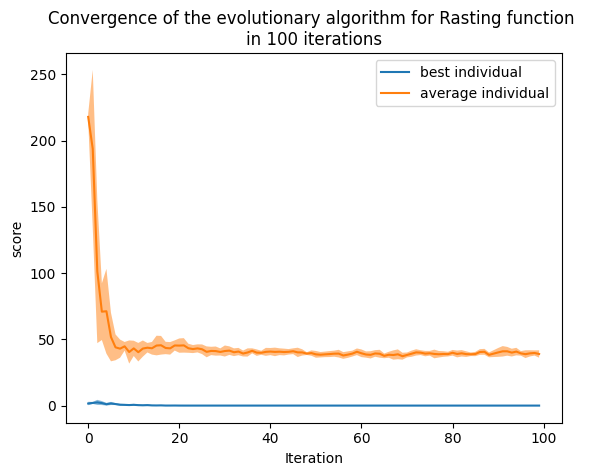

In [223]:
import seaborn as sns

max_iter = 100

n_times = 10
res = np.zeros((n_times, max_iter))
avg_res = np.zeros((n_times, max_iter))
for i in range(n_times):
    best, temp, avg_temp = run(max_iter=max_iter, population_size=1000, tol=0, sigma_0=0.1, elite = 100, func=rasting_func, dim=5, low=-5.12, high=5.12)
    res[i] = temp[-max_iter:]
    avg_res[i] = avg_temp[-max_iter:]
    
plt.fill_between(range(max_iter), np.mean(res, axis = 0) - np.std(res, axis = 0), np.mean(res, axis = 0) + np.std(res, axis = 0), alpha = 0.5)
plt.fill_between(range(max_iter), np.mean(avg_res, axis = 0) - np.std(avg_res, axis = 0), np.mean(avg_res, axis = 0) + np.std(avg_res, axis = 0), alpha = 0.5)

plt.plot(range(max_iter), np.mean(res, axis = 0), label="best individual")
plt.plot(range(max_iter), np.mean(avg_res, axis = 0), label="average individual")

plt.title("Convergence of the evolutionary algorithm for Rasting function \nin 100 iterations")

plt.xlabel("Iteration")
plt.ylabel("score")
plt.legend()
plt.show()

In [224]:
print("Best individual: ", res[:,-1].mean(), "+-", res[:,-1].std())

Best individual:  0.0002543155503112863 +- 0.0002836095875940432
